In [1]:
import wandb
import numpy as np

import torch
import torchvision
from torchvision import transforms as transforms
from torchvision import models

import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf

In [2]:
print("Torch version:      ",torch.__version__, "\nTensorflow_version: ",tf.__version__)

Torch version:       1.11.0+cu102 
Tensorflow_version:  2.8.0


In [2]:
!nvidia-smi

Tue May 31 04:49:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN X ...  Off  | 00000000:03:00.0  On |                  N/A |
| 23%   28C    P8     8W / 250W |    128MiB / 12194MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Difference between CNN and DNN
----------------------

Drawback of DNNs:
1. DNN are prone to overfitting(due to many parameters)
2. Gradients can vanish due to long chains

* Difference:
    * DNNs which are complex (many non-linearities) but have fewer parameters and hence less prone to overfitting is when CNN is used
    * In DNNs we take aggregation of all input, in CNN we take aggregation of small neighbourhood(for a CNN we only consider a small localised neighborhood of inputs when calculating the output, instead of the entire input layer as in the case of DNNs)
    * In CNN, instead of learning the final classifier weights directly, we should also learn to transform the input into a suitable representation through multiple layers of representations and learn the kernel weights for all of those representations instead of using hand-crafted kernels.

- CNN
    * weighted sum of neighbours. 
    * major terminology
        * kernel/filter
        * padding
        * stride
        * feature map
        * convolution
        * Pooling
    * Features of CNN
        * Sparse Connectivity
        * Weight sharing
* Reference:
    - https://stackoverflow.com/questions/42883547/intuitive-understanding-of-1d-2d-and-3d-convolutions-in-convolutional-neural-n
    - https://wandb.ai/ayush-thakur/dl-question-bank/reports/Intuitive-understanding-of-1D-2D-and-3D-convolutions-in-convolutional-neural-networks---VmlldzoxOTk2MDA
    - Project
        - 1D-CNN: Human activity recognition(https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/)
        - 1D-CNN: time series forecasting(https://boostedml.com/2020/04/1-d-convolutional-neural-networks-for-time-series-basic-intuition.html)
    - Using LSTM in PyTorch(https://wandb.ai/sauravmaheshkar/LSTM-PyTorch/reports/Using-LSTM-in-PyTorch-A-Tutorial-With-Examples--VmlldzoxMDA2NTA5?galleryTag=pytorch)
    - Under the hood LSTM(https://wandb.ai/authors/rnn-viz/reports/Under-the-Hood-of-LSTMs--VmlldzoyNjY0MTg?galleryTag=intermediate)

Outline
---------------
1. Download CIFAR10 datase
2. Dataloader in torch.utils
3. Single and multiple convolutional layers
4. LeNet
    * Training
    * Training on GPU
5. Visualization

In [15]:
# The dataset is divided into five training batches and one test batch, each with 10000 images. 
# The test batch contains exactly 1000 randomly-selected images from each class.

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())

0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


* Reference for CIFAutils dataset
- This tech report (Chapter 3) describes the dataset and the methodology followed when collecting it in much greater detail. Please cite it if you intend to use this dataset.
- Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.

In [4]:
classes = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=6)

In [31]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape) # [4,3,32,32] [Batch_size, Col_dim(RGB), Length, Width]
print(images[0].shape,"\nLabel:", classes[labels[0].item()])

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32]) 
Label: horse


In [32]:
# visualize data
npimg = images[0].numpy()
print(npimg.shape)

(3, 32, 32)


In [33]:
npimg = np.transpose(npimg, (1,2,0)) # transposing the image to dimension len, width, channel
print(npimg.shape)

(32, 32, 3)


In [5]:
def plot_img(img):
    img = img.numpy()
    plt.figure(figsize=(4,4))
    # plt.title(classes[label])
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()

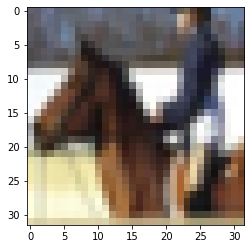

In [52]:
plot_img(images[0])

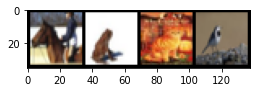

horse	frog	cat	bird


In [55]:
plot_img(torchvision.utils.make_grid(images))
print("\t".join(classes[int(labels[j])] for j in range(4)))

In [66]:
# single convolution layer
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__() # calling init of parent class
        # in_channel=3, out_channel = 16*16, kernel_size = 3*3, padding = (1,1), stride = (2,2)
        self.conv1 = nn.Conv2d(3,16,3, padding=(1,1), stride=(1,1)) # since our input is of 4 dim: len,wid,channel,batch_size, we are applying 2d conv operation
    
    def forward(self, x):
        x = self.conv1(x)
        return x

In [67]:
%%time
net = SimpleCNN()
# [4, 16, 30, 30]: [batch_size, num_output_channel(16 channels are used), len, width]
out = net(images) #input_img is of shape: [4, 3, 32, 32]
out.shape

CPU times: user 135 ms, sys: 0 ns, total: 135 ms
Wall time: 24.4 ms


torch.Size([4, 16, 32, 32])

In [68]:
for param in net.parameters():
    #[16, 3, 3, 3]: [wts_of_kernels(16 kernels), input_channels(RGB), kernel_shape(3*3)]
    #another :[16] : [bias](each kernel has 1 bias term)
    print(param.shape) 

torch.Size([16, 3, 3, 3])
torch.Size([16])


(32, 32)


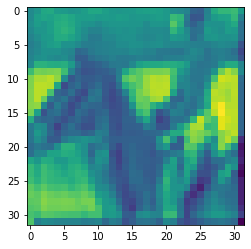

In [69]:
out1 = out[0,0,:,:].detach().numpy() # detaching it to make numpy array
print(out1.shape)

plt.imshow(out1)
plt.show()

In [75]:
# single convolution layer
class TwoLayerCNN(nn.Module):
    def __init__(self):
        super(TwoLayerCNN, self).__init__() # calling init of parent class
        # in_channel=3, out_channel = 16*16, kernel_size = 3*3, padding = (1,1), stride = (2,2)
        self.model = nn.Sequential(nn.Conv2d(3,8,3), #i/p tensor:[N,3,32,32] -> [N,8,30,30]: o/p tensor
                                  nn.Conv2d(8,16,3)) # [N,8,30,30] -> [N,16,28,28]
    
    def forward(self, x):
        x = self.model(x)
        return x

In [76]:
%%time
twonet = TwoLayerCNN()
two_out = twonet(images)
two_out.shape

CPU times: user 2.22 ms, sys: 0 ns, total: 2.22 ms
Wall time: 1.48 ms


torch.Size([4, 16, 28, 28])

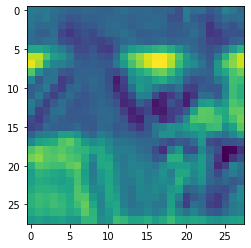

In [77]:
plt.imshow(two_out[0,0,:,:].detach().numpy())

In [78]:
# single convolution layer
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__() # calling init of parent class
        self.model = nn.Sequential(nn.Conv2d(3,6,5),          #[N,3,32,32] -> [N,6,28,28]
                                   nn.AvgPool2d(2, stride=2), #[N,6,28,28] -> [N,6,14,14]
                                   nn.Conv2d(6,16,5),         #[N,6,14,14] -> [N,16,10,10] 
                                  nn.AvgPool2d(2, stride=2))  #[N,16,10,10]  -> [N,16,5,5]
    
    def forward(self, x):
        x = self.model(x)
        return x

In [79]:
%%time
deep_net=  DeepCNN()
deep_out = deep_net(images)
deep_out.shape

CPU times: user 166 ms, sys: 0 ns, total: 166 ms
Wall time: 74.9 ms


torch.Size([4, 16, 5, 5])

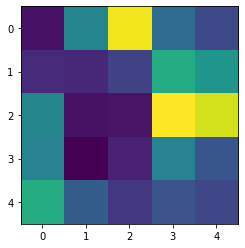

In [80]:
plt.imshow(deep_out[0,0,:,:].detach().numpy())

In [30]:
# LeNet Architecture
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        #building cnn block
        self.cnn = nn.Sequential(nn.Conv2d(3,6,5),         # [N,3,32,32] -> [N,6,28,28]
                                nn.ReLU(),                 # [N,6,28,28] -> [N,6,28,28]
                                nn.AvgPool2d(2, stride=2), # [N,6,28,28] -> [N,6,14,14]
                                nn.Conv2d(6,16,5),         # [N,6,14,14] -> [N,16,10,10]
                                nn.ReLU(),                 # [N,16,10,10] -> [N,16,10,10]
                                nn.AvgPool2d(2, stride=2)) # [N,16,10,10] -> [N,16,5,5]
        #building FFN block
        self.ffn = nn.Sequential(nn.Linear(400,120),       #[N,400] -> [N, 120]
                                nn.ReLU(),                 #[N, 120] -> [N, 120]
                                nn.Linear(120,84),         #[N, 120] -> [N, 84]
                                nn.ReLU(),                 #[N, 84] -> [N, 84]
                                nn.Linear(84,10))          #[N, 84] -> [N, 10]
    
    def forward(self, x):
        x = self.cnn(x)
        #print("After Cnn block: ",x.shape)
        #Flattening the tensor, keeping the first dimension: x.size(0) and collapsing the rest into one
        x = x.view(x.size(0), -1)
        #print("After view: ",x.shape)
        
        x = self.ffn(x)
        #print("After FFN block: ",x.shape)
        #as softmax is not done, the output will be largest value
        return x

In [84]:
%%time
le_net = LeNet()
le_out = le_net.forward(images)
le_out.shape

After Cnn block:  torch.Size([4, 16, 5, 5])
After view:  torch.Size([4, 400])
After FFN block:  torch.Size([4, 10])
CPU times: user 55.1 ms, sys: 0 ns, total: 55.1 ms
Wall time: 10.5 ms


torch.Size([4, 10])

In [89]:
print(le_out)

tensor([[ 0.0386, -0.0014,  0.1269,  0.0581,  0.0668, -0.0034,  0.0406, -0.1101,
          0.0333,  0.0512],
        [ 0.0311,  0.0027,  0.1349,  0.0623,  0.0740,  0.0013,  0.0304, -0.1067,
          0.0143,  0.0519],
        [ 0.0136,  0.0014,  0.1323,  0.0599,  0.0721, -0.0097,  0.0369, -0.1078,
          0.0013,  0.0517],
        [ 0.0178,  0.0070,  0.1195,  0.0572,  0.0787, -0.0033,  0.0443, -0.0918,
          0.0240,  0.0412]], grad_fn=<AddmmBackward0>)


In [91]:
max_val, pred_class = torch.max(le_out.data, 1)
print(pred_class)

tensor([2, 2, 2, 2])


In [7]:
# Trainig LeNet model
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root="./data/", train=True,download=True,transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root="./data/", train=False,download=True,transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        outputs = lenet(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [9]:
lenet = LeNet()
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(lenet.parameters())

  6%|▋         | 1/16 [00:20<05:01, 20.07s/it]

Epoch: 0/16, Test acc: 42.21, Train acc: 42.92


 12%|█▎        | 2/16 [00:40<04:40, 20.02s/it]

Epoch: 1/16, Test acc: 46.83, Train acc: 47.74


 19%|█▉        | 3/16 [00:59<04:19, 19.94s/it]

Epoch: 2/16, Test acc: 49.17, Train acc: 50.30


 25%|██▌       | 4/16 [01:19<03:59, 19.93s/it]

Epoch: 3/16, Test acc: 50.19, Train acc: 51.98


 31%|███▏      | 5/16 [01:40<03:42, 20.25s/it]

Epoch: 4/16, Test acc: 52.19, Train acc: 54.74


 38%|███▊      | 6/16 [02:01<03:23, 20.33s/it]

Epoch: 5/16, Test acc: 53.21, Train acc: 56.21


 44%|████▍     | 7/16 [02:21<03:02, 20.32s/it]

Epoch: 6/16, Test acc: 54.45, Train acc: 58.37


 50%|█████     | 8/16 [02:41<02:42, 20.26s/it]

Epoch: 7/16, Test acc: 55.30, Train acc: 59.75


 56%|█████▋    | 9/16 [03:01<02:20, 20.10s/it]

Epoch: 8/16, Test acc: 54.53, Train acc: 59.76


 62%|██████▎   | 10/16 [03:21<02:00, 20.15s/it]

Epoch: 9/16, Test acc: 55.51, Train acc: 61.41


 69%|██████▉   | 11/16 [03:41<01:41, 20.21s/it]

Epoch: 10/16, Test acc: 55.55, Train acc: 62.27


 75%|███████▌  | 12/16 [04:01<01:20, 20.14s/it]

Epoch: 11/16, Test acc: 56.36, Train acc: 63.36


 81%|████████▏ | 13/16 [04:21<01:00, 20.01s/it]

Epoch: 12/16, Test acc: 56.16, Train acc: 64.67


 88%|████████▊ | 14/16 [04:41<00:39, 19.97s/it]

Epoch: 13/16, Test acc: 56.09, Train acc: 65.19


 94%|█████████▍| 15/16 [05:01<00:19, 19.99s/it]

Epoch: 14/16, Test acc: 57.20, Train acc: 66.17


100%|██████████| 16/16 [05:21<00:00, 20.09s/it]

Epoch: 15/16, Test acc: 56.30, Train acc: 66.04


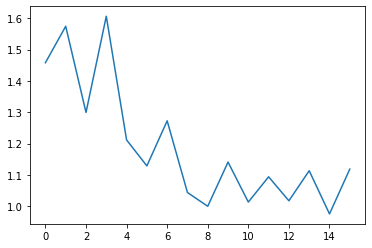

CPU times: user 33min 50s, sys: 7.18 s, total: 33min 58s
Wall time: 5min 21s


In [13]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 16

for epoch in tqdm(range(max_epochs)):
    for i, data in enumerate(trainloader, 0):
        inputs, label = data
        
        opt.zero_grad()
        
        outputs = lenet(inputs)
        loss = loss_fn(outputs, label)
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
    loss_epoch_arr.append(loss.item())
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f'%(epoch, max_epochs, evaluation(testloader), evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

In [15]:
# Relu activation function
lenet = LeNet()
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(lenet.parameters())

  6%|▋         | 1/16 [00:14<03:39, 14.66s/it]

Epoch: 0/16, Test acc: 39.51, Train acc: 39.19


 12%|█▎        | 2/16 [00:29<03:25, 14.71s/it]

Epoch: 1/16, Test acc: 47.08, Train acc: 47.17


 19%|█▉        | 3/16 [00:44<03:10, 14.66s/it]

Epoch: 2/16, Test acc: 50.02, Train acc: 49.98


 25%|██▌       | 4/16 [00:58<02:56, 14.75s/it]

Epoch: 3/16, Test acc: 51.57, Train acc: 52.53


 31%|███▏      | 5/16 [01:13<02:41, 14.72s/it]

Epoch: 4/16, Test acc: 52.95, Train acc: 54.30


 38%|███▊      | 6/16 [01:28<02:26, 14.67s/it]

Epoch: 5/16, Test acc: 54.08, Train acc: 55.79


 44%|████▍     | 7/16 [01:42<02:12, 14.67s/it]

Epoch: 6/16, Test acc: 55.72, Train acc: 57.31


 50%|█████     | 8/16 [01:57<01:57, 14.71s/it]

Epoch: 7/16, Test acc: 55.33, Train acc: 57.49


 56%|█████▋    | 9/16 [02:12<01:42, 14.71s/it]

Epoch: 8/16, Test acc: 56.31, Train acc: 58.41


 62%|██████▎   | 10/16 [02:26<01:28, 14.70s/it]

Epoch: 9/16, Test acc: 57.11, Train acc: 59.89


 69%|██████▉   | 11/16 [02:41<01:13, 14.65s/it]

Epoch: 10/16, Test acc: 58.23, Train acc: 61.30


 75%|███████▌  | 12/16 [02:56<00:58, 14.60s/it]

Epoch: 11/16, Test acc: 58.34, Train acc: 62.00


 81%|████████▏ | 13/16 [03:10<00:43, 14.56s/it]

Epoch: 12/16, Test acc: 58.46, Train acc: 62.51


 88%|████████▊ | 14/16 [03:24<00:29, 14.55s/it]

Epoch: 13/16, Test acc: 58.51, Train acc: 62.20


 94%|█████████▍| 15/16 [03:39<00:14, 14.59s/it]

Epoch: 14/16, Test acc: 59.65, Train acc: 64.06


100%|██████████| 16/16 [03:54<00:00, 14.65s/it]

Epoch: 15/16, Test acc: 60.31, Train acc: 64.93


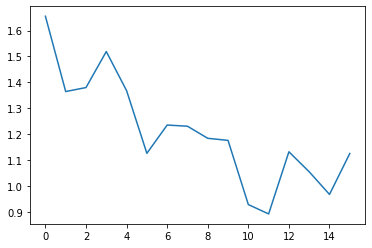

CPU times: user 25min 6s, sys: 1.74 s, total: 25min 7s
Wall time: 3min 54s


In [16]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 16

for epoch in tqdm(range(max_epochs)):
    for i, data in enumerate(trainloader, 0):
        inputs, label = data
        
        opt.zero_grad()
        
        outputs = lenet(inputs)
        loss = loss_fn(outputs, label)
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
    loss_epoch_arr.append(loss.item())
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f'%(epoch, max_epochs, evaluation(testloader), evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

In [20]:
# SELU activation function
lenet = LeNet()
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(lenet.parameters())

  6%|▋         | 1/16 [00:15<03:58, 15.87s/it]

Epoch: 0/16, Test acc: 40.09, Train acc: 40.42


 12%|█▎        | 2/16 [00:30<03:34, 15.29s/it]

Epoch: 1/16, Test acc: 44.47, Train acc: 44.36


 19%|█▉        | 3/16 [00:45<03:16, 15.11s/it]

Epoch: 2/16, Test acc: 47.09, Train acc: 46.97


 25%|██▌       | 4/16 [01:00<02:59, 14.99s/it]

Epoch: 3/16, Test acc: 48.44, Train acc: 49.35


 31%|███▏      | 5/16 [01:15<02:44, 14.95s/it]

Epoch: 4/16, Test acc: 48.90, Train acc: 50.51


 38%|███▊      | 6/16 [01:30<02:29, 14.95s/it]

Epoch: 5/16, Test acc: 50.69, Train acc: 51.88


 44%|████▍     | 7/16 [01:45<02:14, 14.91s/it]

Epoch: 6/16, Test acc: 51.14, Train acc: 51.93


 50%|█████     | 8/16 [01:59<01:58, 14.86s/it]

Epoch: 7/16, Test acc: 51.24, Train acc: 52.84


 56%|█████▋    | 9/16 [02:14<01:43, 14.79s/it]

Epoch: 8/16, Test acc: 52.41, Train acc: 54.49


 62%|██████▎   | 10/16 [02:29<01:28, 14.80s/it]

Epoch: 9/16, Test acc: 53.97, Train acc: 56.57


 69%|██████▉   | 11/16 [02:44<01:13, 14.78s/it]

Epoch: 10/16, Test acc: 53.74, Train acc: 56.38


 75%|███████▌  | 12/16 [02:59<00:59, 14.84s/it]

Epoch: 11/16, Test acc: 55.33, Train acc: 58.01


 81%|████████▏ | 13/16 [03:14<00:44, 14.88s/it]

Epoch: 12/16, Test acc: 52.32, Train acc: 55.29


 88%|████████▊ | 14/16 [03:28<00:29, 14.88s/it]

Epoch: 13/16, Test acc: 55.07, Train acc: 58.10


 94%|█████████▍| 15/16 [03:43<00:14, 14.92s/it]

Epoch: 14/16, Test acc: 53.93, Train acc: 57.68


100%|██████████| 16/16 [03:58<00:00, 14.93s/it]

Epoch: 15/16, Test acc: 57.14, Train acc: 61.19


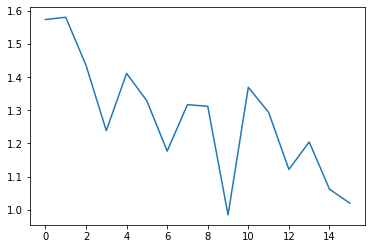

CPU times: user 25min 30s, sys: 2.58 s, total: 25min 33s
Wall time: 3min 58s


In [21]:
%%time
loss_LeNetr = []
loss_epoch_arr = []
max_epochs = 16

for epoch in tqdm(range(max_epochs)):
    for i, data in enumerate(trainloader, 0):
        inputs, label = data
        
        opt.zero_grad()
        
        outputs = lenet(inputs)
        loss = loss_fn(outputs, label)
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
    loss_epoch_arr.append(loss.item())
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f'%(epoch, max_epochs, evaluation(testloader), evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

In [22]:
# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [23]:
def evaluation_gpu(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = lenet(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

def training_gpu(max_epochs = 30):
    for epoch in tqdm(range(max_epochs)):
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            opt.zero_grad()

            outputs = lenet(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()

In [31]:
lenet = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(lenet.parameters())

In [33]:
%%time
max_epochs = 30

for epoch in tqdm(range(max_epochs)):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        opt.zero_grad()
        
        outputs = lenet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
    print('Epoch: %d/%d'%(epoch, max_epochs))

  3%|▎         | 1/30 [00:06<03:00,  6.21s/it]

Epoch: 0/30


  7%|▋         | 2/30 [00:12<02:54,  6.22s/it]

Epoch: 1/30


 10%|█         | 3/30 [00:18<02:47,  6.21s/it]

Epoch: 2/30


 13%|█▎        | 4/30 [00:24<02:41,  6.21s/it]

Epoch: 3/30


 17%|█▋        | 5/30 [00:31<02:35,  6.21s/it]

Epoch: 4/30


 20%|██        | 6/30 [00:37<02:27,  6.15s/it]

Epoch: 5/30


 23%|██▎       | 7/30 [00:43<02:20,  6.11s/it]

Epoch: 6/30


 27%|██▋       | 8/30 [00:49<02:13,  6.08s/it]

Epoch: 7/30


 30%|███       | 9/30 [00:55<02:07,  6.06s/it]

Epoch: 8/30


 33%|███▎      | 10/30 [01:01<02:00,  6.04s/it]

Epoch: 9/30


 37%|███▋      | 11/30 [01:07<01:55,  6.06s/it]

Epoch: 10/30


 40%|████      | 12/30 [01:13<01:49,  6.08s/it]

Epoch: 11/30


 43%|████▎     | 13/30 [01:19<01:43,  6.09s/it]

Epoch: 12/30


 47%|████▋     | 14/30 [01:25<01:37,  6.08s/it]

Epoch: 13/30


 50%|█████     | 15/30 [01:31<01:31,  6.09s/it]

Epoch: 14/30


 53%|█████▎    | 16/30 [01:37<01:25,  6.10s/it]

Epoch: 15/30


 57%|█████▋    | 17/30 [01:43<01:19,  6.12s/it]

Epoch: 16/30


 60%|██████    | 18/30 [01:50<01:13,  6.14s/it]

Epoch: 17/30


 63%|██████▎   | 19/30 [01:56<01:07,  6.16s/it]

Epoch: 18/30


 67%|██████▋   | 20/30 [02:02<01:01,  6.17s/it]

Epoch: 19/30


 70%|███████   | 21/30 [02:08<00:55,  6.19s/it]

Epoch: 20/30


 73%|███████▎  | 22/30 [02:14<00:49,  6.16s/it]

Epoch: 21/30


 77%|███████▋  | 23/30 [02:21<00:43,  6.17s/it]

Epoch: 22/30


 80%|████████  | 24/30 [02:27<00:37,  6.17s/it]

Epoch: 23/30


 83%|████████▎ | 25/30 [02:33<00:30,  6.17s/it]

Epoch: 24/30


 87%|████████▋ | 26/30 [02:39<00:24,  6.15s/it]

Epoch: 25/30


 90%|█████████ | 27/30 [02:45<00:18,  6.12s/it]

Epoch: 26/30


 93%|█████████▎| 28/30 [02:51<00:12,  6.08s/it]

Epoch: 27/30


 97%|█████████▋| 29/30 [02:57<00:06,  6.07s/it]

Epoch: 28/30


100%|██████████| 30/30 [03:03<00:00,  6.12s/it]

Epoch: 29/30
CPU times: user 3min 9s, sys: 180 ms, total: 3min 9s
Wall time: 3min 3s


In [34]:
!nvidia-smi

Mon May 30 10:58:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN X ...  Off  | 00000000:03:00.0  On |                  N/A |
| 30%   54C    P2    56W / 250W |   1032MiB / 12194MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
# 15 epochs and SELU activation function
print("Test_accuracy: %0.2f, Train_accuracy: %0.2f"%(evaluation_gpu(testloader), evaluation_gpu(trainloader)))

Test_accuracy: 56.65, Train_accuracy: 60.72


In [35]:
# After 30epochs and ReLu activation function
print("Test_accuracy: %0.2f, Train_accuracy: %0.2f"%(evaluation_gpu(testloader), evaluation_gpu(trainloader)))

Test_accuracy: 57.44, Train_accuracy: 67.88


In [41]:
# plotting cnn output
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=6)
dataiter = iter(trainloader)
images, labels = dataiter.next()

<Figure size 576x288 with 0 Axes>

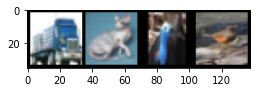

truck	cat	bird	bird


In [42]:
plot_img(torchvision.utils.make_grid(images))
print("\t".join(classes[int(labels[j])] for j in range(4)))

In [83]:
lenet = LeNet()
out = lenet.cnn[0](images) 
out.shape #[4, 6, 28, 28] : [batch_size, channels, len, width]

torch.Size([4, 6, 28, 28])

<Figure size 288x288 with 0 Axes>

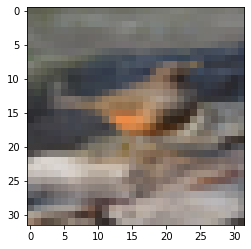

In [44]:
image_id = 3
plt.figure(figsize=(4,4))
plot_img(images[image_id,])

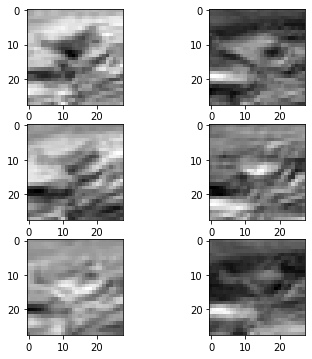

In [81]:
plt.figure(figsize=(6,6))
plt.subplot(321)
for i in range(6):
    ax1 = plt.subplot(3,2,i+1)
    plt.imshow(out[image_id, i, :, :].detach().numpy(), cmap="gray")
plt.show()

In [84]:
out2 = lenet.cnn[3](out) 
out2.shape #[4, 16, 24, 24] : [batch_size, channels, len, width]

torch.Size([4, 16, 24, 24])

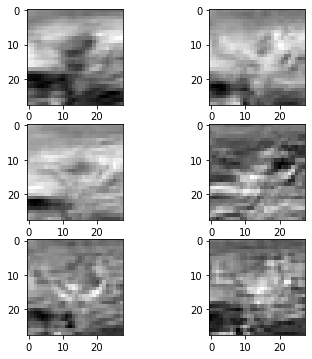

In [85]:
plt.figure(figsize=(6,6))
plt.subplot(321)
for i in range(6):
    ax1 = plt.subplot(3,2,i+1)
    plt.imshow(out[image_id, i, :, :].detach().numpy(), cmap="gray")
plt.show()

In [86]:
# Adding regularization: weight decay
# It is a regularization technique(L2 norm): loss = loss + weight decay parameter * L2 norm of the weights
#        - to aviod overfitting
#        - to avoid exploding gradient
lenet = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(lenet.parameters(), weight_decay=0.5)

In [87]:
%%time
max_epochs = 30

for epoch in tqdm(range(max_epochs)):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        opt.zero_grad()
        
        outputs = lenet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
    print('Epoch: %d/%d'%(epoch, max_epochs))

  3%|▎         | 1/30 [00:28<13:38, 28.24s/it]

Epoch: 0/30


  7%|▋         | 2/30 [00:56<13:14, 28.37s/it]

Epoch: 1/30


 10%|█         | 3/30 [01:25<12:45, 28.37s/it]

Epoch: 2/30


 13%|█▎        | 4/30 [01:53<12:17, 28.38s/it]

Epoch: 3/30


 17%|█▋        | 5/30 [02:21<11:50, 28.42s/it]

Epoch: 4/30


 20%|██        | 6/30 [02:50<11:22, 28.46s/it]

Epoch: 5/30


 23%|██▎       | 7/30 [03:19<10:54, 28.48s/it]

Epoch: 6/30


 27%|██▋       | 8/30 [03:47<10:27, 28.52s/it]

Epoch: 7/30


 30%|███       | 9/30 [04:15<09:57, 28.47s/it]

Epoch: 8/30


 33%|███▎      | 10/30 [04:44<09:29, 28.47s/it]

Epoch: 9/30


 37%|███▋      | 11/30 [05:12<09:00, 28.45s/it]

Epoch: 10/30


 40%|████      | 12/30 [05:41<08:31, 28.44s/it]

Epoch: 11/30


 43%|████▎     | 13/30 [06:09<08:03, 28.42s/it]

Epoch: 12/30


 47%|████▋     | 14/30 [06:38<07:35, 28.48s/it]

Epoch: 13/30


 50%|█████     | 15/30 [07:06<07:06, 28.43s/it]

Epoch: 14/30


 53%|█████▎    | 16/30 [07:34<06:37, 28.40s/it]

Epoch: 15/30


 57%|█████▋    | 17/30 [08:03<06:10, 28.49s/it]

Epoch: 16/30


 60%|██████    | 18/30 [08:31<05:41, 28.43s/it]

Epoch: 17/30


 63%|██████▎   | 19/30 [09:00<05:12, 28.41s/it]

Epoch: 18/30


 67%|██████▋   | 20/30 [09:28<04:44, 28.43s/it]

Epoch: 19/30


 70%|███████   | 21/30 [09:57<04:15, 28.42s/it]

Epoch: 20/30


 73%|███████▎  | 22/30 [10:25<03:47, 28.38s/it]

Epoch: 21/30


 77%|███████▋  | 23/30 [10:53<03:18, 28.36s/it]

Epoch: 22/30


 80%|████████  | 24/30 [11:22<02:50, 28.41s/it]

Epoch: 23/30


 83%|████████▎ | 25/30 [11:50<02:21, 28.35s/it]

Epoch: 24/30


 87%|████████▋ | 26/30 [12:18<01:53, 28.39s/it]

Epoch: 25/30


 90%|█████████ | 27/30 [12:47<01:25, 28.42s/it]

Epoch: 26/30


 93%|█████████▎| 28/30 [13:16<00:57, 28.50s/it]

Epoch: 27/30


 97%|█████████▋| 29/30 [13:44<00:28, 28.47s/it]

Epoch: 28/30


100%|██████████| 30/30 [14:12<00:00, 28.43s/it]

Epoch: 29/30
CPU times: user 12min 34s, sys: 56 s, total: 13min 30s
Wall time: 14min 12s


In [89]:
# After 30epochs and ReLu activation function and weight decay=0.5
print("Test_accuracy: %0.2f, Train_accuracy: %0.2f"%(evaluation_gpu(testloader), evaluation_gpu(trainloader)))

Test_accuracy: 10.00, Train_accuracy: 10.00


In [91]:
lenet = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(lenet.parameters(), weight_decay=1e-3)

In [92]:
%%time
training_gpu(max_epochs=15)

100%|██████████| 15/15 [07:06<00:00, 28.43s/it]

CPU times: user 6min 16s, sys: 28.3 s, total: 6min 45s
Wall time: 7min 6s


In [93]:
# After 30epochs and ReLu activation function and weight decay=0.001
print("Test_accuracy: %0.2f, Train_accuracy: %0.2f"%(evaluation_gpu(testloader), evaluation_gpu(trainloader)))

Test_accuracy: 58.05, Train_accuracy: 61.86


In [94]:
%%time
lenet = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(lenet.parameters(), weight_decay=1e-2)

training_gpu(max_epochs=15)

# After 30epochs and ReLu activation function and weight decay=0.01
print("Test_accuracy: %0.2f, Train_accuracy: %0.2f"%(evaluation_gpu(testloader), evaluation_gpu(trainloader)))

100%|██████████| 15/15 [07:07<00:00, 28.52s/it]


Test_accuracy: 39.30, Train_accuracy: 39.54
CPU times: user 6min 29s, sys: 30.5 s, total: 6min 59s
Wall time: 7min 22s


Outline 2
--------------------
1. Loading dataset: tranforming images
2. VGG-16 model
3. Pre-trained models/ Transfer Learning
4. Storing intermediate models
5. RESNET model
6. Inception v3
7. VisionTransformer

In [3]:
# using extra features of transforms, where we can use augmentation or transformation of our dataset
transform_train = transforms.Compose([transforms.RandomResizedCrop(224), # to crop the image at random location with size 224
                                     transforms.ToTensor(),              # convert image to tensor 
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) # (mean of 0.5),(std_dev of 0.5) for all three channels, so most data lie b/w 0-1
transform_test  = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) 

In [4]:
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
testset  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
num_classes = 10
batch_size = 4
classes = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

In [8]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape, images[1].shape)
print(classes[labels[1].item()])

torch.Size([4, 3, 224, 224]) torch.Size([3, 224, 224])
dog


In [9]:
# Plotting images
def plot_images(img, title):
    # we are converting the img to numpy and un-normalizing the image: /0.5 (multuplying by 0.5) for std_dev and adding 0.5 for mean
    npimg = img.numpy() / 2 + 0.5  # if we don't un-normalize then images will be dark
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Transposing the image to dim (1,2,0): (len, wid, channel)
    title = [classes[i] for i in title]
    plt.title(title)
    plt.show()

def show_batch(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    plot_images(img, title=[int(x.item()) for x in labels])

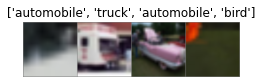

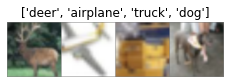

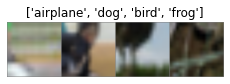

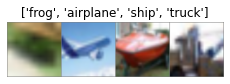

In [10]:
for i in range(4):
    show_batch(trainloader)

#### VGG model

- Using Pytorch model zoo:
    * https://pytorch.org/vision/stable/models.html

In [11]:
vgg = models.vgg16_bn() #VGG 16-layer model (configuration "D") with batch normalization
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [12]:
vgg.features[0], vgg.classifier[-1] #out_features=1000, but in our case it should be 10

(Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Linear(in_features=4096, out_features=1000, bias=True))

In [13]:
final_in_feat = vgg.classifier[-1].in_features # take the final classifier input_features
mod_classifier = list(vgg.classifier.children())[:-1] #creating list of classifier's children except last layer
mod_classifier.extend([nn.Linear(final_in_feat, num_classes)]) #extending the last last layer in modifier classifier with new num_classes
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [14]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [24]:
batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [16]:
def evaluation_vgg(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [17]:
# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
vgg_model = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.005)

In [22]:
def train_models(model):
    loss_epoch_arr = []
    max_epochs = 1

    n_iters = np.ceil(2000/batch_size)

    for epoch in tqdm(range(max_epochs)):
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            opt.zero_grad()
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()
            
            del inputs, labels, outputs
            torch.cuda.empty_cache()
            
            if i % 100 == 0:
                print("Iteration: %d/%d, Loss: %0.2f" % (i, n_iters, loss.item()))
        loss_epoch_arr.append(loss.item())
        
        print("Epochs: %d/%d, Test_acc: %0.2f, Train_acc: 0.2%f",(
        epochs, max_epochs, evaluation_gpu(testloader, evaluation_vgg),evaluation_gpu(trainloader, evaluation_vgg)))

In [25]:
%%time
train_models(vgg_model)

  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 0/500, Loss: 2.39
Iteration: 100/500, Loss: 2.38
Iteration: 200/500, Loss: 2.28
Iteration: 300/500, Loss: 2.30
Iteration: 400/500, Loss: 2.43
Iteration: 500/500, Loss: 2.23
Iteration: 600/500, Loss: 2.43
Iteration: 700/500, Loss: 2.35
Iteration: 800/500, Loss: 2.41
Iteration: 900/500, Loss: 2.36


  0%|          | 0/1 [01:23<?, ?it/s]

Iteration: 1000/500, Loss: 2.33


KeyboardInterrupt: 